In [2]:
import numpy as np
import pandas as pd
import sys
import glob
import pickle
import matplotlib.pyplot as plt
import time

## Separating Sources into Fields

1. Obtain the right ascension and declination of all of the pointings within each of MeerKAT's LSPs
2. Group sources from the database into these fields
3. Generate a schedule based on the amount of time given to each LSP (70\% of total observing time) and asdf

Keep a list of source_ids for each pointing. Each source_id can belong to more than one pointing. To keep track of which sources have been observed and which haven't, I'll keep a list of previously observed sources. 

### 1. Right Ascension and Declination of All LSPs

In [3]:
labels = ['Mhongoose', 'LADUMA', 'Fornax', 'MeerTime MSP', 
          'MeerTime Binary', 'MeerTime 1000 PTA', 'MeerTime Globular Clusters', 'TRAPUM Globular Clusters', 
          'TRAPUM Fermi','TRAPUM Nearby Galaxies', 'Mightee L-band', 'Mightee S-band', 'MALS']
sort_idx = np.argsort(labels)
labels = np.array(labels)[sort_idx]
files = np.sort(glob.glob('../sim_data/*csv'))


In [53]:
project_coords = {}

ra_proj = np.array([])
dec_proj = np.array([])

for i, f in enumerate(files):
    tb = pd.read_csv(f)
    project_coords[labels[i]] = tb.loc[:, ['ra_deg', 'dec_deg']]
    ra_proj = np.append(ra_proj, tb.loc[:, ['ra_deg']])
    dec_proj = np.append(dec_proj, tb.loc[:, ['dec_deg']])

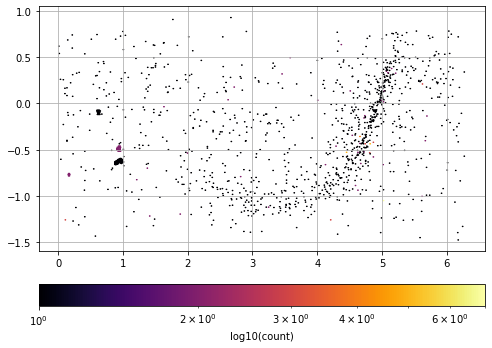

In [64]:
p_ra = Angle(ra_proj, unit = u.deg)#.wrap_at(180. * u.degree)
p_dec = Angle(dec_proj, unit = u.deg)

fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(111)
hb = ax.hexbin(p_ra.radian, p_dec.radian, gridsize = 500, cmap='inferno',bins='log',mincnt=1)
cb = fig2.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
cb.set_label('log10(count)')
ax.grid(True)
plt.show()

### 2. Group Sources by Pointings

In [5]:
targets = pd.read_csv('../../../reduced_target_list.csv')
targets = targets.rename(columns={'Unnamed: 0':'id'})

In [6]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * np.rad2deg(np.arcsin(np.sqrt(a)))

In [7]:
project_sources = {}

for key, value in project_coords.items():
    project_sources[key] = []
    print (key)
    for row in value.iterrows():
        in_view = haversine(row[1]['ra_deg'], row[1]['dec_deg'], targets.loc[:, 'ra'], targets.loc[:, 'decl']) < 0.5
        project_sources[key].append(targets.loc[in_view, ['id']])


Fornax


KeyboardInterrupt: 

with open('coordinate_dict_id.pkl', 'wb') as f:
    pickle.dump(project_sources, f)

In [7]:
with open('../sim_data/coordinate_dict_id.pkl', 'rb') as f:
    sources = pickle.load(f)

### 3. Generate the Observing Schedule

MALS: ~1650 hours, ~1100 pointings

Percentage of time each project receives. This will determine how likely they are to be selected for observation.

In [8]:
lsp_time = np.array([1650, 3424, 900, 2160, 1440, 720, 1080, 320, 338, 226, 979, 948, 1650]) * 3600. # Time in seconds
lsp_time = lsp_time[sort_idx]
disc_time = 0.3 / 0.7 * lsp_time.sum()
alloted_time = np.append(lsp_time, disc_time)
total_time = lsp_time.sum() + disc_time
prob = np.append(lsp_time, disc_time) / total_time

print (total_time)

schedule = []
obs_time = 30 * 60. # 0.5 hour observation blocks

for i in range(int(total_time / obs_time)):
    idx = np.random.choice(np.arange(prob.shape[0]), p = prob)
    schedule.append(idx)
    alloted_time[idx] -= obs_time
    total_time -= obs_time
    prob = alloted_time / total_time.sum()
    if np.any(prob[prob < 0]):
        prob[prob < 0] = 0
    prob /= prob.sum()

81437142.85714287


In [9]:
schedule = np.array(schedule)

In [10]:
def random_pointing(ra1 = 0.0, dec1 = -np.pi / 2.0, ra2 = 2 * np.pi, dec2 = np.pi / 4.0):
    """Random pointing in the MeerKAT field of view
    """
    return np.random.uniform(low = ra1, high = ra2), np.random.uniform(low = dec1, high = dec2)

In [297]:
observed_sources = np.array([])
n_beams = 64
tot_sources = int(n_beams * obs_time / (5. * 60.))
tot_sources_observed = 0
source_list = []

start = time.time()

for p_idx in np.array([1] * 100):
    source_list.append(tot_sources_observed)
    
    if p_idx == 13:
        ra, dec = random_pointing()
        in_view = haversine(ra, dec, targets.loc[:, 'ra'], targets.loc[:, 'decl']) < 0.5
        pointing = targets.loc[in_view, ['id']]
        
    else:
        fields = sources[labels[p_idx]]
        pointing = fields[np.random.randint(len(fields))]
        
    unobserved_sources = pointing.loc[~pointing.isin(observed_sources).id, :]
    srcs = np.array(unobserved_sources.iloc[:tot_sources, :]).ravel()
    tot_sources_observed += srcs.shape[0]
    observed_sources = np.append(observed_sources,srcs)
    
np.save('sim_obs.npy', source_list)
print ('1000 blocks run in {} seconds'.format(time.time() - start))

1000 blocks run in 0.2108149528503418 seconds


In [22]:
ras = []
decs = []
for i, p_idx in enumerate(schedule):
    if p_idx == 13:
        ra, dec = random_pointing()
        
    else:
        fields = project_coords[labels[p_idx]]
        pointing = fields.iloc[np.random.randint(len(fields))]
        ra = pointing['ra_deg']
        dec = pointing['dec_deg']
        
    ras.append(ra)
    decs.append(dec)

In [35]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u

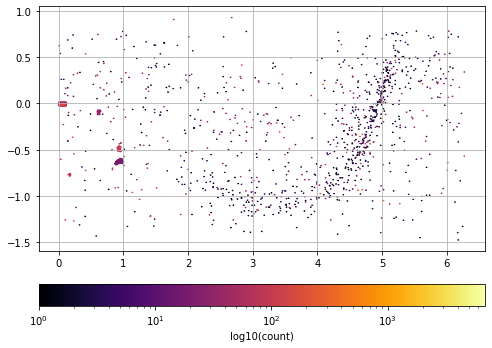

In [63]:
pra = Angle(ras, unit = u.deg)#.wrap_at(180. * u.degree)
pdec = Angle(decs, unit = u.deg)

fig2 = plt.figure(figsize=(8,6))
#ax = fig2.add_subplot(111, projection="mollweide")
ax = fig2.add_subplot(111)
hb1 = ax.hexbin(pra.radian, pdec.radian, gridsize = 500, cmap='inferno',bins='log',mincnt=1)
cb = fig2.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()